In [23]:
pip install -r requirements.txt

     |████████████████████████████████| 153kB 242kB/s eta 0:00:01    |████▎                           | 20kB 262kB/s eta 0:00:01
     |████████████████████████████████| 81kB 4.5MB/s eta 0:00:011
  Stored in directory: /Users/yuanwenliang/Library/Caches/pip/wheels/a9/ef/7c/7bbf228825e8717adaa84cd4b6c4ed8649b7958dd2bac45076
Successfully built geojsonio
Note: you may need to restart the kernel to use updated packages.


## Creating Area of Interest (AOI)

**Important: the way load() in Image moudlue is weriod. It doesn't follow the convention that in (i,j), i reprensents row and j reprensents column. It's other way round.**

In [1]:
from PIL import Image, ImageDraw
test = Image.new("RGBA", (2, 2))
test.putdata([(0,0,0,0),(255,255,255,255),(0,0,0,255),(123,123,123,255)])

for i in range(2):
    for j in range(2):
        print(i,j)
        print(test.load()[i,j])

#test.show()

0 0
(0, 0, 0, 0)
0 1
(0, 0, 0, 255)
1 0
(255, 255, 255, 255)
1 1
(123, 123, 123, 255)


In [140]:
from PIL import Image, ImageDraw
import glob
import os
import numpy as np
from PIL import Image, ImageDraw
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from rasterio import plot


# The initial release contains only one tile, so lets hardcode its location
# here.  When you have more tiles, you can update this
TILE_X = 7680
TILE_Y = 10240


# The expected value of a Pixel in a mask file indicating that the pixel is
# within that region.  Tuple value, (Red, Green, Blue, Alpha)
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

# Tile width / height in pixels

TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512

# Get the physical path to the PNG image containing the mask file
def get_mask_path(tile_x, tile_y, mask_type): #mask_type is sugarcane-region coz it's in the file name
    path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/masks/{mask_type}-mask.png"
    return path


# Get a list of all the image tiles for a specific x,y coordinate
# for the specified band
def get_timeseries_image_paths(tile_x, tile_y, band, date):
    path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/timeseries/{tile_x}-{tile_y}-{band}-{date}.png"
    #path = glob.glob(path)
    #path = path[0] # get the first date 
    return path 

def get_cropped_image_paths(tile_x, tile_y, band, date):
    path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/cropped/cropped-{tile_x}-{tile_y}-{band}-{date}.png"
    #path = glob.glob(path)
    #path = path[0] # get the first date 
    return path 


# Open an image file and get all the pixels, be careful of the x,y swaps
def get_image_pixels(path):
    img = Image.open(path)
    pixels = img.load() 
    return pixels

def pixels_swap(pixels,pixel_x,pixel_y):
    pixels[pixel_x,pixel_y] = pixels[pixel_y,pixel_x]
    return pixels
    
def is_in_mask(mask_pixels, pixel_x, pixel_y):
    if mask_pixels[pixel_x,pixel_y] == IS_IN_MASK_PIXEL_VALUE: # the pixel in the mask file is black 
        return True 
    else:
        return False

    
def get_cropped_pixels(tile_x, tile_y, mask_type, band, date):
    
    # get the pixels from mask and image 
    mask_pixels = get_image_pixels(get_mask_path(tile_x, tile_y, mask_type))
    image_pixels = get_image_pixels(get_timeseries_image_paths(tile_x, tile_y, band, date))
    
    
    width = TILE_WIDTH_PX 
    height = TILE_HEIGHT_PX 
    bands = Image.open(get_timeseries_image_paths(tile_x, tile_y, band, date)).getbands()
    num_channels = np.shape(bands)[0]

    for x in range(0, width):
        for y in range(0, height):

            # is the pixel in my mask?
            in_mask = is_in_mask(mask_pixels, x, y)
            if in_mask:
                pass
            else:
                if num_channels == 3:
                    image_pixels[x,y] = (0,0,0,0) #if not in mask, change to transparent
                else:
                    image_pixels[x,y] = 0 # not sure about this, what does 0 in "I" mean?
    
    cropped_pixels = image_pixels
    print("The png file is in " + str(bands) + " mode.")
    return cropped_pixels
    

def sequence_cropped_pixels(tile_x, tile_y, mask_type, band, date):
    
    # get the pixels from cropped
    cropped_pixels = get_cropped_pixels(tile_x, tile_y, mask_type, band, date)

    cropped_sequence = []
    
    width = TILE_WIDTH_PX 
    height = TILE_HEIGHT_PX 
    for i in range(0, width):
        for j in range(0, height):
            cropped_sequence.append(cropped_pixels[j,i]) 
            # flipping the image coz of the way load() reads pixels
    return cropped_sequence



def save_cropped(tile_x, tile_y, mask_type, band, date):
    cropped = Image.new("I", (512, 512))
    cropped.putdata(sequence_cropped_pixels(tile_x, tile_y, mask_type, band, date))
    #cropped.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT)
    cropped.save(f'./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/cropped/cropped-{tile_x}-{tile_y}-{band}-{date}.png')
    return cropped

def save_cropped_TCI(tile_x, tile_y, mask_type, date, band='TCI'):
    cropped = Image.new("RGB", (512, 512))
    cropped.putdata(sequence_cropped_pixels(tile_x, tile_y, mask_type, band, date))
    #cropped.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT)
    cropped.save(f'./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/cropped/cropped-{tile_x}-{tile_y}-{band}-{date}.png')
    return cropped

The png file is in ('I',) mode.


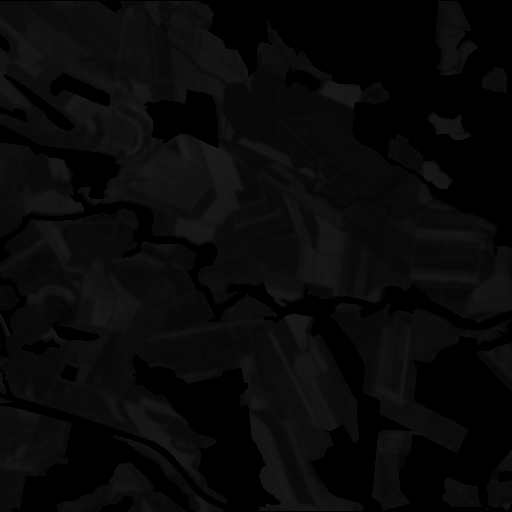

In [139]:
# just saving one band one date
img = Image.open(get_timeseries_image_paths(TILE_X, TILE_Y, 
                                            'B12','2016-12-22'))

save_cropped(TILE_X, TILE_Y, mask_type="sugarcane-region", 
             band='B12', date = '2016-12-22')


The png file is in ('R', 'G', 'B') mode.


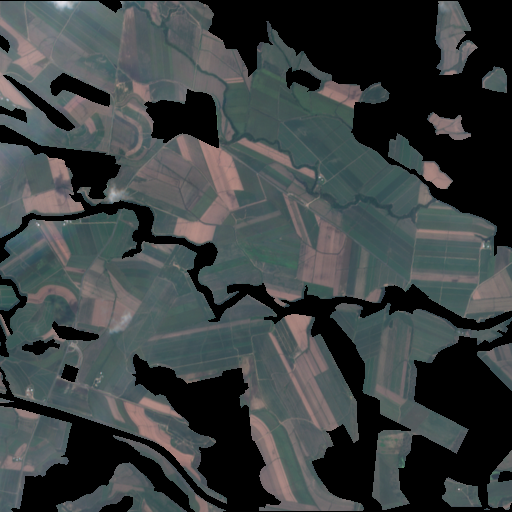

In [128]:
# just saving one band one date
save_cropped_TCI(TILE_X, TILE_Y, mask_type="sugarcane-region", 
             date = '2016-12-22')


In [110]:
# comparing a pixel value in a cropped png and a original png
pixel = get_image_pixels(get_timeseries_image_paths(TILE_X, TILE_Y, band='B04', date = '2016-12-22'))[0,1]
print(pixel)
pixel = get_image_pixels(get_cropped_image_paths(TILE_X, TILE_Y, band='B04', date = '2016-12-22'))[0,1]
print(pixel)

2852
2852


### Understanding image Modes:
modes: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#modes

pixels:
https://www.harrisgeospatial.com/docs/Image_Types.html

### 2 methods of getting pixels

In [36]:
img = Image.open(get_timeseries_image_paths(TILE_X, TILE_Y, 'B04','2016-12-22'))
pixels = img.load()
for i in range(5):
    for j in range(5):
        print(i,j)
        print(pixels[i,j])
img.show()

0 0
2764
0 1
2852
0 2
2848
0 3
2886
0 4
2872
1 0
2724
1 1
2684
1 2
2608
1 3
2618
1 4
2620
2 0
2464
2 1
2506
2 2
2546
2 3
2584
2 4
2562
3 0
2438
3 1
2528
3 2
2562
3 3
2556
3 4
2524
4 0
2396
4 1
2518
4 2
2578
4 3
2564
4 4
2552


In [51]:
img = Image.open(get_timeseries_image_paths(TILE_X, TILE_Y, 'B04','2016-12-22'))
pixels = np.asarray(img) # this is read-only
for i in range(5):
    for j in range(5):
        print(i,j)
        print(pixels[i,j])
        #pixels[i,j] = 0

0 0
2764
0 1
2724
0 2
2464
0 3
2438
0 4
2396
1 0
2852
1 1
2684
1 2
2506
1 3
2528
1 4
2518
2 0
2848
2 1
2608
2 2
2546
2 3
2562
2 4
2578
3 0
2886
3 1
2618
3 2
2584
3 3
2556
3 4
2564
4 0
2872
4 1
2620
4 2
2562
4 3
2524
4 4
2552


(512, 512, 4)


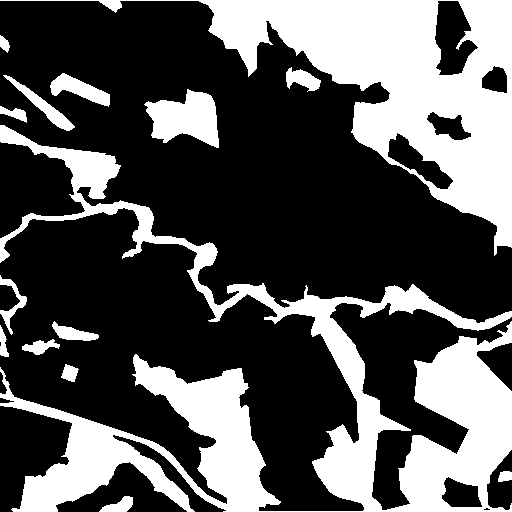

In [38]:
img = Image.open(get_mask_path(TILE_X, TILE_Y, mask_type="sugarcane-region"))
pixels = np.asarray(img)
print(np.shape(pixels))
im = Image.fromarray(pixels)
im